# Select wildfire burn area predictors 

### This will be done using Laso 

This notebook will be used to see how laso selection works. I am going to see what met predictors work best at accounting for wildfire burn area for each grid box. I am going to insert random nonsense into the predictor matrix as a way to test that I know what laso is doing and to ensure that these random predictors are discarded... If they are not, then these methods do not work as I understan or hoped. 

Show predicted values vs actual for the data used to create the model and the data I set aside. 

Use every environmental variable available as a predictor (e.g. T, Tp, RH, ScfWind, VPD, ...), then, create lagged versions of these data as predictors as well. For example, shift the environmental arrays by minus one month, so that the month before the burn area occurs is used as the predictor. Do this for different time lags. Do this the other way too to help determine the validity of our methods. If temperature 5 months after a wildfire is the best predictor of wildfire occurrence, the model is doing something that can not represent an actual environmental predictor. 

TODO: Should I consider using random years worth of data with Lasso and testing performance on the other half of the random years for learning purposes? Yes. 

In [1]:
# Import needed libraries and paths to local data 

import numpy as np
from netCDF4 import Dataset
import os
%matplotlib inline
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC, Lasso
from sklearn import datasets
import time
import pandas as pd
from sklearn.feature_selection import SelectFromModel

from sklearn import metrics


# Modules I have written 
import model_dictionary as md # md, you know, like the helpful kind of doctor

import random


### In our work, we are interested in predicting total summer burn area. 

#### Lets start by selecting the besy predictors for June, July, August burn area

[236.25 238.75 241.25 243.75 246.25 248.75 251.25 253.75 256.25]
[31. 33. 35. 37. 39. 41. 43. 45. 47. 49.]


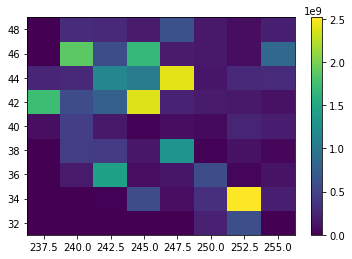

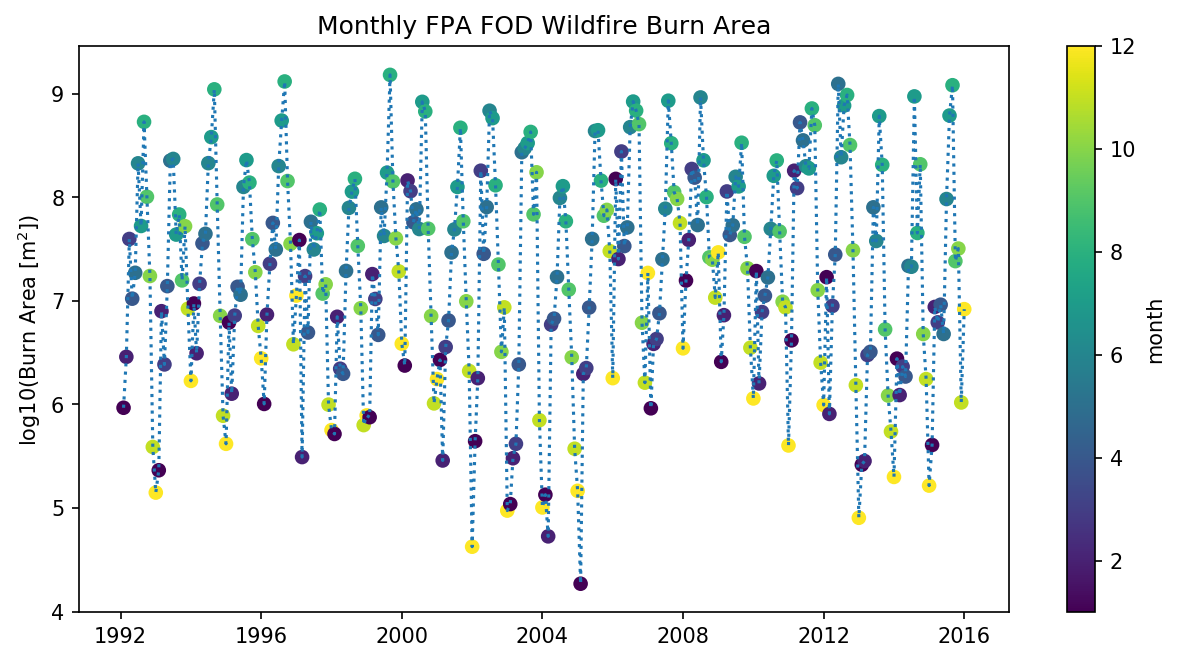

In [2]:
# Get the values we need to predict, burn area
burnFile = os.path.join("..", "Data", "Fire", "FPA_FOD", 'burn_area_monthly_COMMON_GRID_1992_2015.nc')
nc = Dataset(burnFile, 'r')
BA = nc.variables['burn_area'][:]
t = nc.variables['time'][:]
x = nc.variables['lon'][:]
y = nc.variables['lat'][:]
nc.close()

# Get an array to allow easy subsetting of time
t_fire = pd.date_range("1992-01-01", periods=len(t), freq="M")

# Spatially subset these data to the western US 
minLon=235.
maxLon=258. 
minLat=31. 
maxLat=49.
lonIndex = np.where( ( (x >= minLon) & (x <= maxLon)) )[0]
latIndex = np.where( ( (y >= minLat) & (y <= maxLat) ) )[0]
timeIndex = range(0, BA.shape[0])
BA_subset = BA[np.ix_(timeIndex, latIndex, lonIndex)]

print x[lonIndex]
print y[latIndex]

plt.figure()
plt.pcolor(x[lonIndex], y[latIndex], np.sum(BA_subset, axis=0))
plt.colorbar()
plt.show()

# Sum the burn area in the domain (Western US for now, will be individual grid boxes later)
y = np.sum(BA_subset, axis=(1,2))
ylog = np.log10(y)

# Create a dataframe of values related to burn area
BA_df = pd.DataFrame({"date":t_fire, "year":t_fire.year, "month":t_fire.month, "BA_m2":y})

plt.figure(figsize=(10,5), dpi=150)
plt.plot(t_fire, ylog, linestyle=":")
plt.scatter(t_fire, ylog, c=BA_df['month'])
plt.colorbar(label="month")
plt.ylabel("log10(Burn Area [m$^{2}$])")
plt.title("Monthly FPA FOD Wildfire Burn Area")
plt.show()

In [3]:
# Get nc data entire western US spatial averages 
def get_era_nc_vals(var="tas", minLon=235., maxLon=256., minLat=31., maxLat=49., spatialMean=False):
    """This function will be for loading a particular nc file, which will be spatially subset.
    The defualt latitude longitude values cover the western US."""
    
    # Create link to the monthly file
    dataDir = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
    f = var + "_1990-2015.nc" 

    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! Data logs indicate that not all requests exist
    if(not os.path.isfile(loadFile)):
        raise ValueError(f + " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Pandas handling of time so all models have the exact same origin and such. 
    t = nc.variables["time"]
    if(len(t) == 312):
        # Convert to pandas time array, on the assumption t[0]=2006-01 & t[-1]=2100-12
        t_mon = pd.date_range("1990-01-01", periods=len(t), freq="M")
    else:
        raise ValueError('Error in number of months for file: '+ f + " 312 expected.")
        
    # Now subset the data based on the passed max and min values for lon and lat
    lonIndex = np.where( ((lon >= minLon) & (lon <= maxLon)) )[0]
    latIndex = np.where( ( (lat >= minLat) & (lat <= maxLat) ) )[0]
    timeIndex = range(24, len(t)) # because we want all months, for now

    # Subset the 2D field
    lonCut = lon[lonIndex]
    latCut = lat[latIndex]
    t_monCut = t_mon[timeIndex]

    # Subset the 3D field
    valsCut = vals[np.ix_(timeIndex, latIndex, lonIndex)]

    # take a spatial mean? 
    if spatialMean:
        valsCut = np.mean(valsCut, axis=(1,2))
    
    return valsCut, t_monCut, lonCut, latCut

In [4]:
predictors = ["t2m", "tp", "si10", "RH", "ssrd", "VPD"]
predictorDict = {}
for var in predictors:
    predictorDict[var], t, lon, lat = get_era_nc_vals(var=var,  spatialMean=True)

X = pd.DataFrame(predictorDict)
# TODO: Make sure this is the most sensible way to standardize these data 
Z = (X - np.mean(X)) / np.std(X)

In [5]:
#plt.scatter(Z["temperature"], ylog)
#plt.scatter(si10_, ylog)
#plt.scatter(np.log(vpd_), ylog)
#print np.mean(Z['windSpeed'])
#print np.std(Z['windSpeed'])
#plt.plot(R1)

### Time to start selecting features and create a model using LassoCV


Computing regularization path using the coordinate descent lasso...
Coefs for LassCV
[-0.60040004  0.41335185  0.0130156   0.          0.          0.19202841]


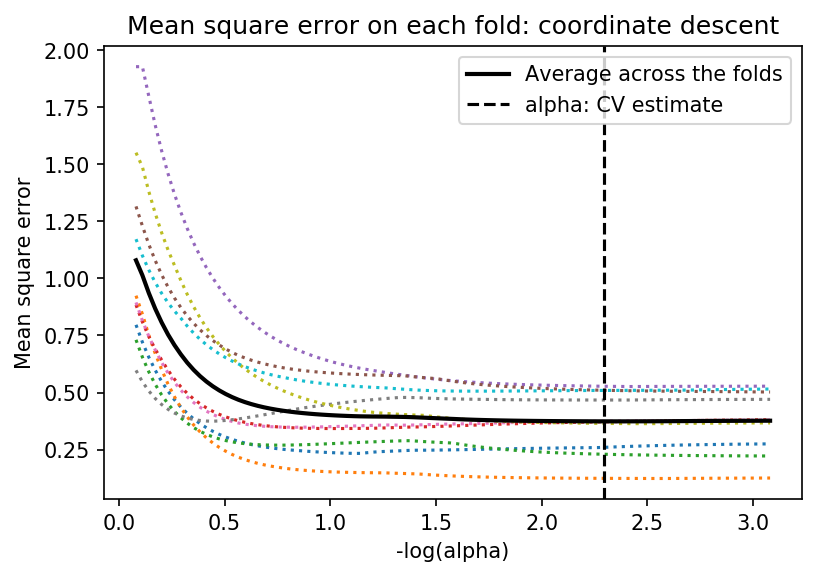

In [6]:
# #############################################################################
# LassoCV: coordinate descent
# Compute paths
# NOTE: So if you're concerned that your model is too overfit and won't generalize well, 
# NOTE: you can always crank up alpha; the coefficients will drop, and the resulting 
# NOTE: model will be less overfit. 

# LassoCV tries to find the best alpha value for you. 

print("Computing regularization path using the coordinate descent lasso...")
# cv sets the number of folds. None makes 3-fold cross-validation
model = LassoCV(cv=10,max_iter = 100000, tol=0.00001).fit(Z, ylog) 

print "Coefs for LassCV"
print model.coef_

# Use the selected alpha_ from "model" as a starting point, and figure out
# what alpha sets  coefs for R1-R3 are zero. 
#coefs = model.coef_ #np.zeros(len(model.coef_))+1.
alpha = model.alpha_ #0.00001 # Start with a small alpha, but one that is not dangerouslu small. 
#while coefs[4] < 0: #or coefs[2] > 0 or coefs[3]:
reg_model = Lasso(alpha=alpha).fit(Z, ylog)
   # coefs = reg_model.coef_
    #alpha = alpha + 0.000001

    
def plot_MSE(model):
    # Display results
    m_log_alphas = -np.log10(model.alphas_)

    plt.figure(dpi=150)
    plt.plot(m_log_alphas, model.mse_path_, ':')
    plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
                label='alpha: CV estimate')
    plt.legend()
    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold: coordinate descent')
    plt.axis('tight')
    plt.show()
    
plot_MSE(model)

### I will not trust the model until R1-R3 and sequence are eliminated.
- Coefficients represent relative importance in the model.
- Alpha varies how harsh the model is, the bigger alpha, the more predictors are eliminated. Alpha = 0 is OLS regression. 
- Is there a smart way to reduce variance by eliminating correlated predictors? 


### NOTE: 
- The plot on the left, which tries to find alpha using different folds of the data and reducing MSE, is VERY sensitive to the number of folds. 

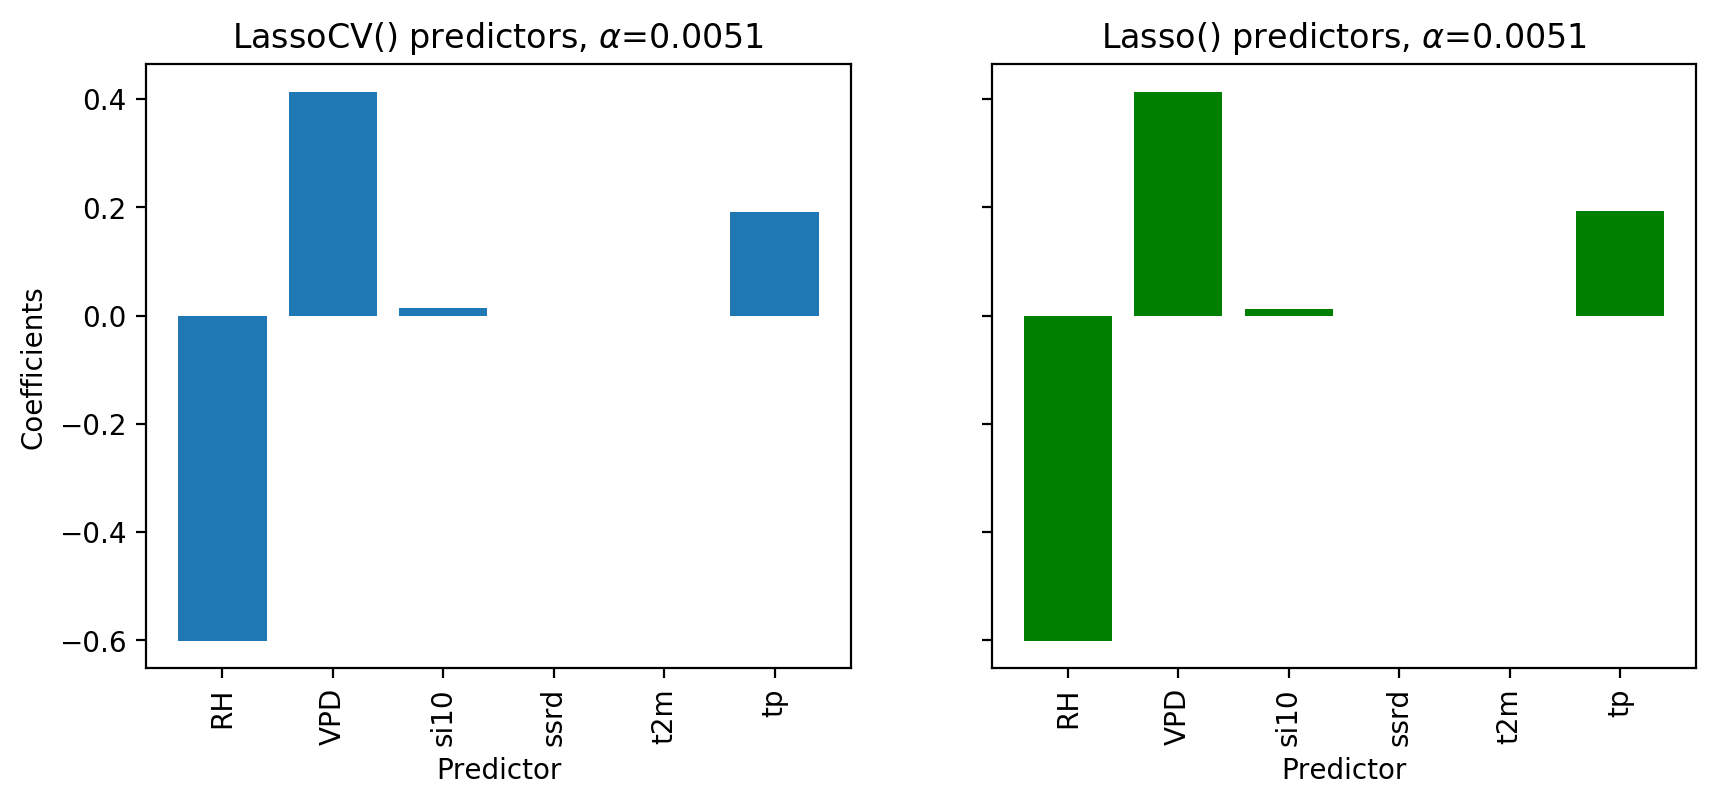

In [7]:
def plot_coefs(model, Z):

    plt.figure(dpi=150, figsize=(10,5))

    plt.bar(x=Z.columns, height=model.coef_)
    plt.xticks(rotation='vertical')
    plt.xlabel("Predictor")
    plt.ylabel("Coefficients")
    plt.title("LassoCV() predictors, $\\alpha$=" + str(np.round(model.alpha_,5)))

    plt.show()

plt.figure(dpi=200, figsize=(10,4))

ax1 = plt.subplot(121)
plt.bar(x=Z.columns, height=model.coef_)
plt.xticks(rotation='vertical')
plt.xlabel("Predictor")
plt.ylabel("Coefficients")
plt.title("LassoCV() predictors, $\\alpha$=" + str(np.round(model.alpha_,5)))

ax2 = plt.subplot(122, sharey=ax1)
plt.bar(x=Z.columns, height=reg_model.coef_, color="green")
plt.xticks(rotation='vertical')
plt.xlabel("Predictor")
plt.ylabel("Coef")
plt.title("Lasso() predictors, $\\alpha$=" + str(np.round(reg_model.alpha, 5)))
plt.setp(ax2.get_yticklabels(), visible=False)
plt.ylabel("")
plt.show()


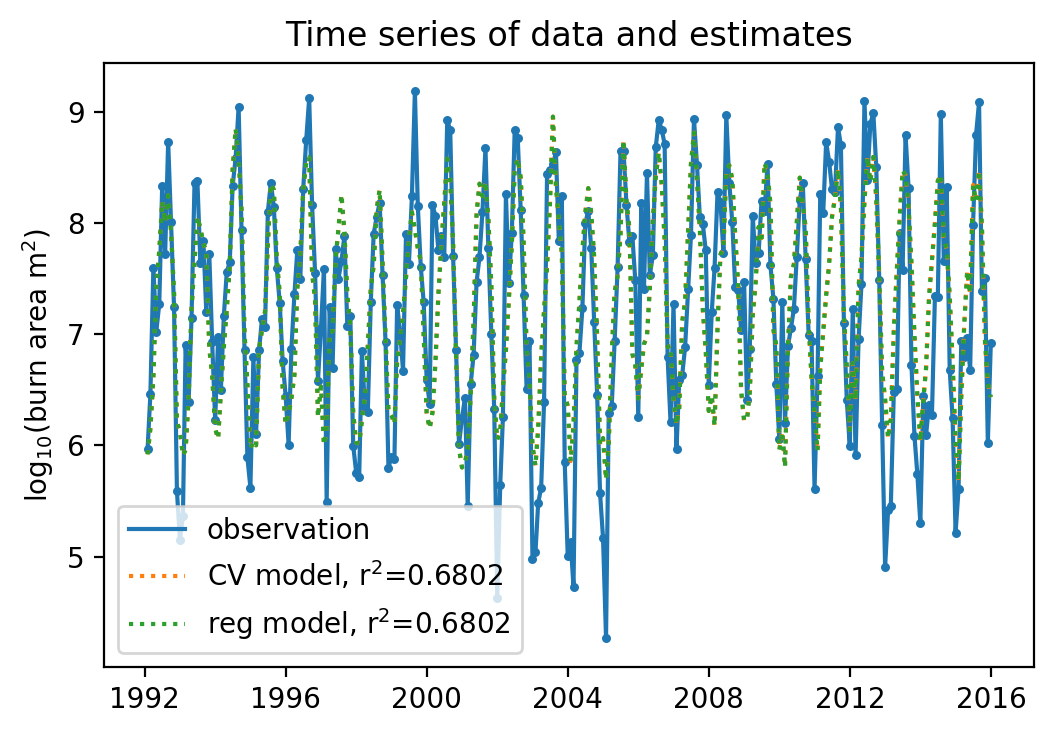

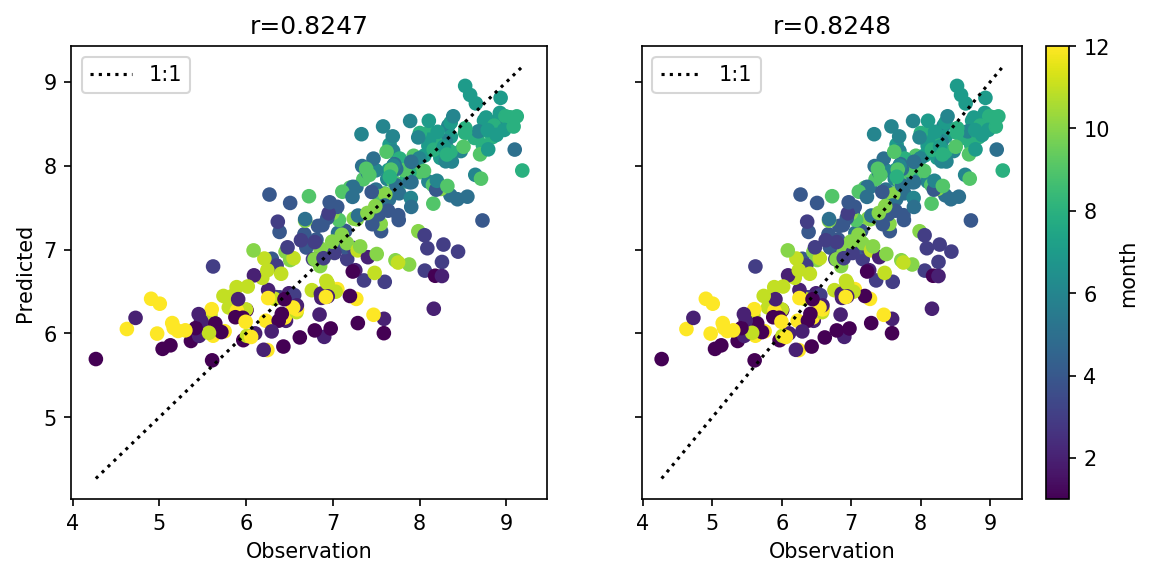

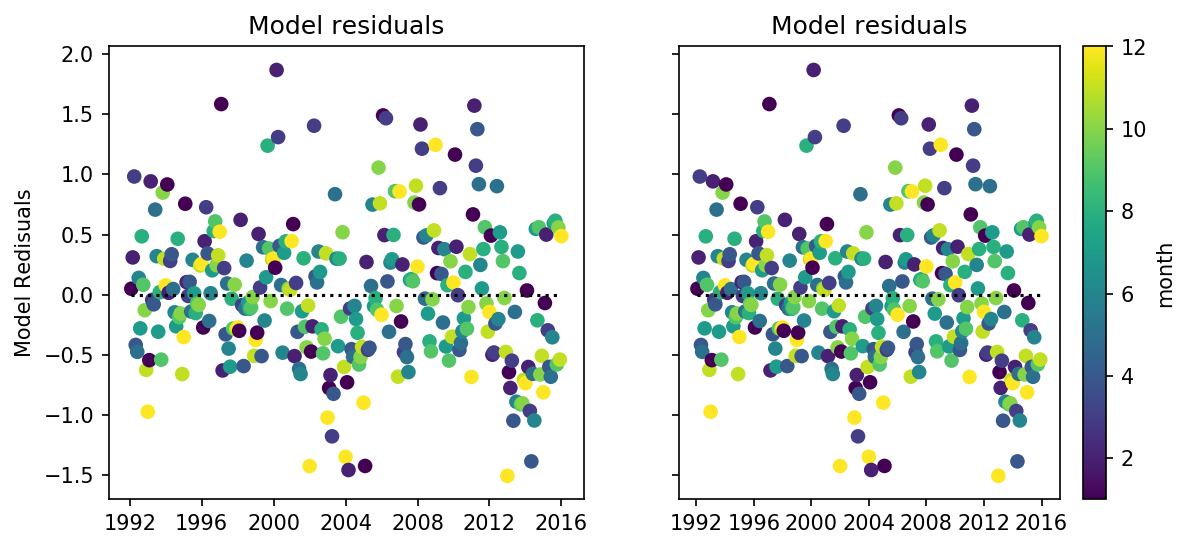

In [8]:
# TODO: Turn this into an evaluation funciton 

# Use the model to get predicted values
y_hat_CV = model.predict(Z)
y_hat_reg = reg_model.predict(Z)

# How well does the model do based on r-squared? 
CV_r2 = np.round(metrics.r2_score(y_true=ylog, y_pred=y_hat_CV),4)
reg_r2 = np.round(metrics.r2_score(y_true=ylog, y_pred=y_hat_reg),4)

########################################
# Plot obs and modeled values for both
########################################
plt.figure(dpi=200)
plt.plot(t_fire, ylog, label="observation")
plt.scatter(t_fire, ylog, s=5)
plt.plot(t_fire, y_hat_CV, label="CV model, r$^{2}$=" + str(CV_r2), linestyle=":")
plt.plot(t_fire, y_hat_reg, label="reg model, r$^{2}$=" + str(reg_r2), linestyle=":")
plt.ylabel("log$_{10}$(burn area m$^{2}$)")
plt.legend()
plt.title("Time series of data and estimates")

plt.show()

# For diag 1:1 on plot for interpretation
x1 = np.linspace( np.min([ylog, y_hat_CV]), np.max([ylog,y_hat_CV]) )
r_CV = np.round(np.corrcoef(ylog, y_hat_CV)[1][0], 4)
r_reg = np.round(np.corrcoef(ylog, y_hat_reg)[1][0], 4)

########################################
# Plot observations vs. modelled values
########################################
plt.figure(dpi=150, figsize=(9,4))
ax1 = plt.subplot(121)
plt.plot(x1, x1, color="k", linestyle=":", label="1:1")
plt.scatter(ylog, y_hat_CV, c=t_fire.month)
plt.xlabel("Observation")
plt.ylabel("Predicted")
plt.title("r="+str(r_CV))
plt.legend()

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(x1, x1, color="k", linestyle=":", label="1:1")
plt.scatter(ylog, y_hat_reg, c=t_fire.month)
plt.xlabel("Observation")
plt.ylabel("")
plt.colorbar(label="month")
plt.title("r="+str(r_reg))
plt.legend()
plt.setp(ax2.get_yticklabels(), visible=False)

plt.show()

########################################
# Plot residuals 
########################################
zero = np.zeros(len(t_fire))
plt.figure(dpi=150, figsize=(9,4))
ax1 = plt.subplot(121)
plt.scatter(t_fire, ylog-y_hat_CV, c=t_fire.month)
plt.plot(t_fire, zero, color="k", linestyle=":")
plt.ylabel("Model Redisuals")
plt.title("Model residuals")

ax2 = plt.subplot(122, sharey=ax1)
plt.scatter(t_fire, ylog-y_hat_reg, c=t_fire.month)
plt.plot(t_fire, zero, color="k", linestyle=":")
plt.ylabel("")
plt.colorbar(label="month")
plt.title("Model residuals")
plt.setp(ax2.get_yticklabels(), visible=False)

plt.show()

# Transition to forecasting summer burn area

## List of summer predictors
- summer, spring, winter,  temperature
- same for all other variables

check 1


,RH_spring,RH_summer,RH_winter,VPD_spring,VPD_summer,VPD_winter,si10_spring,si10_summer,si10_winter,t2m_spring,t2m_summer,t2m_winter,tp_spring,tp_summer,tp_winter
0,55.501331,48.507793,69.892487,676.902893,1238.405151,262.262909,3.387895,3.355550,3.301147,284.886432,292.047154,276.909924,0.066417,0.045479,0.079667
1,58.740406,50.976173,74.296608,615.655823,1128.809082,201.175476,3.653267,3.504146,3.471268,283.795386,290.986219,273.868765,0.080030,0.053399,0.115552
2,54.951214,43.415512,66.229370,653.250183,1494.042236,288.578796,3.616241,3.365082,3.454389,283.972804,293.244360,275.468642,0.057922,0.022861,0.074144
3,60.585571,49.474907,72.885254,521.595459,1243.115723,244.760895,3.847413,3.386811,3.394641,282.232854,291.917920,277.196900,0.099785,0.045364,0.108752
4,56.281628,46.270874,68.262878,653.216431,1364.721436,283.076447,3.946157,3.414682,3.734538,282.957249,292.455015,275.795501,0.071740,0.028663,0.105934
5,55.700245,51.996761,70.435738,658.580811,1193.626221,256.941010,3.820725,3.395253,3.620840,283.325044,292.377952,275.472871,0.063800,0.052203,0.088084
6,60.268215,50.431099,73.592522,521.634338,1261.677979,230.444305,3.614509,3.246826,3.731214,282.212880,292.660454,276.332312,0.079334,0.036045,0.131238
7,55.437603,49.340408,65.969704,583.499268,1191.266235,310.079193,4.042327,3.342825,3.938518,282.114755,291.551964,276.506138,0.066840,0.033307,0.096741
8,54.544891,46.065357,68.996674,692.509583,1376.906738,288.298401,3.843377,3.400272,3.516572,283.833492,292.603797,276.715664,0.057230,0.024450,0.094454
9,55.065189,46.526154,69.624619,677.591003,1376.526733,243.708725,3.707752,3.292998,3.345843,283.514729,292.797953,274.548534,0.052965,0.031410,0.059835


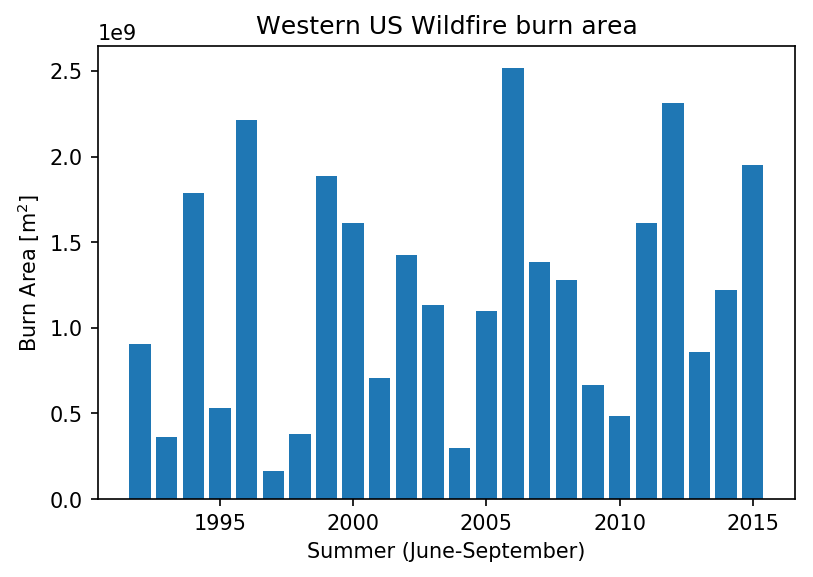

<Figure size 432x288 with 0 Axes>

In [14]:
# Create summer burn area time series
years = np.unique(BA_df.year)
nYears = len(years)
summer_BA = np.zeros(nYears)

# Create season masks (first month last month of season). Each season gets its own 
# column. 
month = pd.Series(t.month)
seasons = {"winter":[1,2], # Make sure to not use months after wildfires in a given year 
           "spring":[3,4,5], 
           "summer":[6,7,8,9]}

# TODO: Add all summer predictors here 
variables = ["t2m", "tp", "si10", "RH", "VPD"]
predictor_dict = {} # To store predictor information 
for pre in variables:
    for s in seasons.keys():
        predictor_name = pre + "_" + s 
        predictor_dict[predictor_name] = np.zeros(nYears)

print "check 1"
        
        
# Loop through years 
for i in range(nYears):
        
    # Mask the year 
    year_mask = years[i] == BA_df.year
    
    # Loop through seasons, within a year
    for s in seasons.keys():
    
        # Mask the months that fall into the current season of interest
        month_mask = month.isin(seasons[s])

        # combine to make a single mask
        tChunk = month_mask & year_mask 
        #print s
        #print t[tChunk] 

        # Take desired stats (mean or sum) of these temporal chunk
        if s == "summer":
            summer_BA[i] = np.sum(BA_df.BA_m2[tChunk])
            #summer_BA[i] = np.sum(BA_df.BA_m2[year_mask])
            #print t[year_mask]

        # For each predictor variable, loop through taking relevant stat
        # TODO: consider an if statement to take sums vs. means of variables
        for pre in variables:
            predictor_dict[pre+"_"+s][i] = np.mean(X[pre][tChunk])
    
# Assign the summer values to this dataframe    
df_summer_predictors = pd.DataFrame(predictor_dict)
    
# TODO: Figure out why the 2015 shown here has such high burn area relative to what is shown in 
# TODO: older figures. My money is on fires from the planes somewhere, probably Texas. 
plt.figure(dpi=150)
plt.bar(years, summer_BA)
plt.title("Western US Wildfire burn area")
plt.ylabel("Burn Area [m$^{2}$]")
plt.xlabel("Summer (June-September)")
plt.figure()

del predictor_dict

df_summer_predictors

In [10]:
X_summmer = df_summer_predictors
Z_summer = (X_summmer - np.mean(X_summmer)) / np.std(X_summmer)
print Z_summer.shape
y_summer = np.log10(summer_BA)
print y_summer.shape

(24, 15)
(24,)


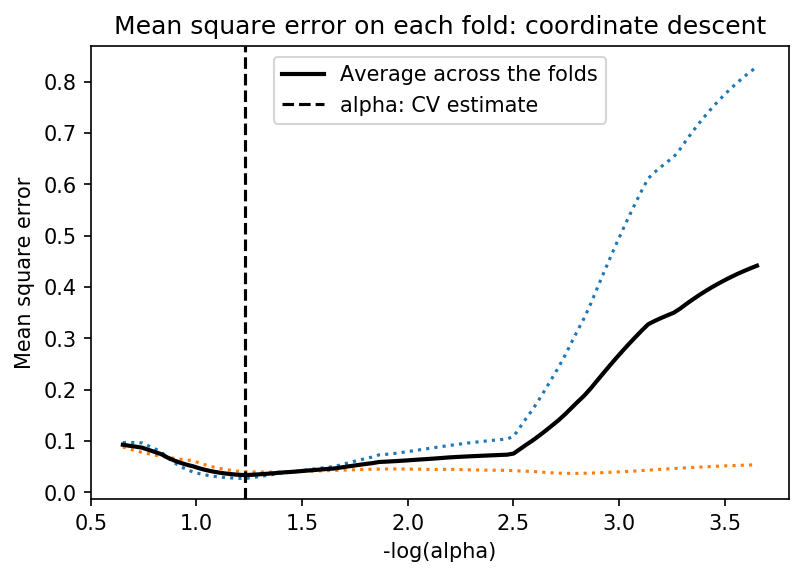

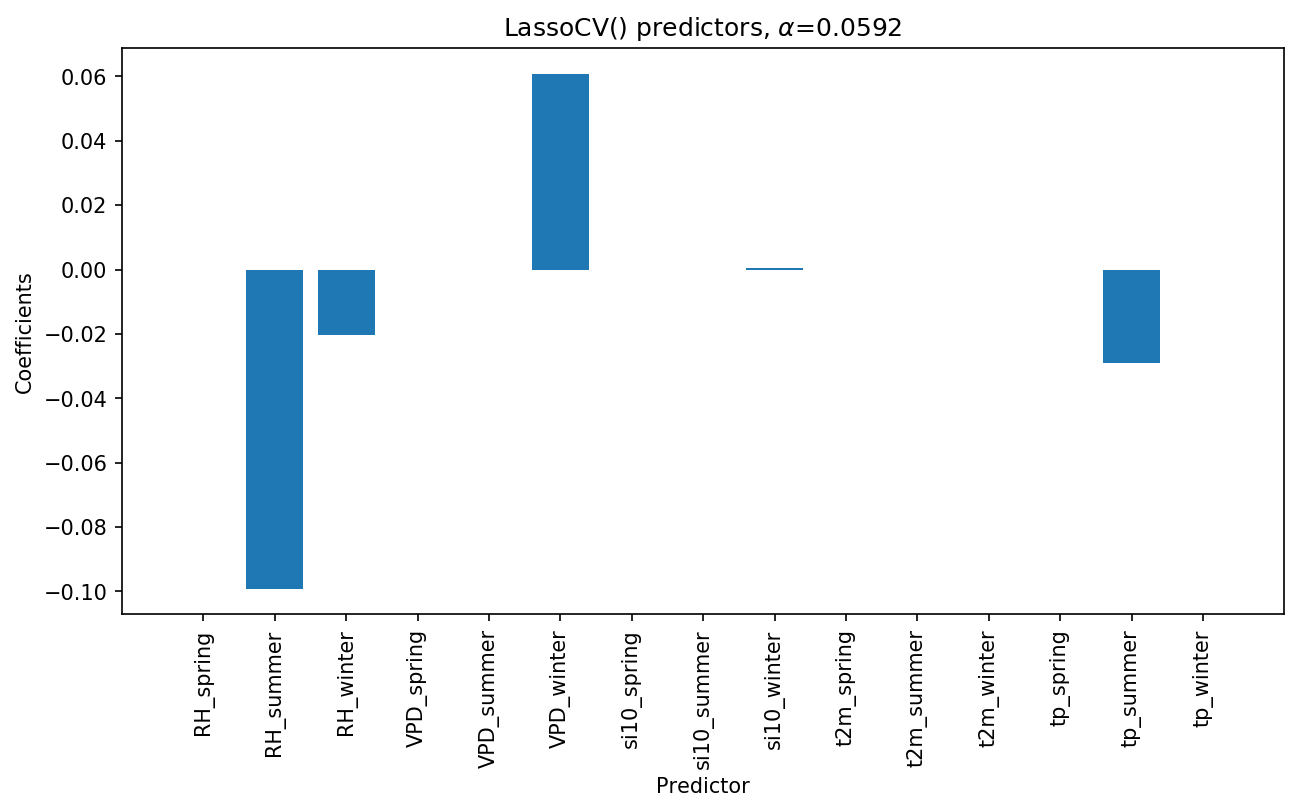

In [11]:
summer_model = LassoCV(cv=2).fit(Z_summer, y_summer) 

plot_MSE(summer_model)
plot_coefs(summer_model, Z_summer)

### Add antecedent predictors 

In [12]:
x = np.array([True, True, False, True])
y = np.array([True, False, True, True])
print x & y

[ True False False  True]


In [13]:
seasons = {"winter":[11,12,1], 
           "spring":[2,3,4,5], 
           "summer":[6,7,8,9]}

In [81]:
s = pd.Series([1,2,3,4,5,6,7,8,9,10,11,12])
s.isin(seasons["spring"])

0     False
1      True
2      True
3      True
4      True
5     False
6     False
7     False
8     False
9     False
10    False
11    False
dtype: bool

In [82]:
pd.Series(np.arange(12)+1)

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
dtype: int64

In [83]:
X

,RH,VPD,si10,ssrd,t2m,tp
0,70.204330,232.554077,3.374135,1.782383e+07,275.223812,0.068812
1,69.580650,291.971741,3.228158,2.357012e+07,278.596036,0.090522
2,62.968609,403.532074,3.108064,3.397460e+07,281.106514,0.080743
3,53.262444,697.115662,3.674597,4.486938e+07,284.980135,0.065764
4,50.272942,930.060913,3.381025,5.233323e+07,288.572647,0.052744
5,48.160191,1207.197021,3.503917,5.388747e+07,291.568655,0.060384
6,50.964943,1263.906006,3.344093,5.206522e+07,292.998781,0.053529
7,46.937935,1378.010498,3.112597,4.827321e+07,293.540345,0.035690
8,47.968098,1104.507080,3.461594,3.986529e+07,290.080835,0.032314
9,53.293053,750.069580,3.074691,2.797362e+07,286.039310,0.051951


In [84]:
len(t)

288

In [70]:
Z["t2m"][tChunk]

281    1.334333
282    1.453366
283    1.530678
284    1.048621
Name: t2m, dtype: float64